# Matteo Caiola               
# Lorenzo Cusin
# Giacomo Serafini
# Andrea Tonello 

# Dataset


The pathology and hematology departments at Libya's Sebha Oncology Center; embody the spatial boundaries of a study. The information was gathered from BC cases that were recorded at the center between 2015 and 2020, Which represents the time limits of the study. The inclusion criteria were all Libyan cases from different regions who were registered during the study at the SOC.

Biomarkers and tumor markers are molecules used to detect the presence of cancer, monitor it, and evaluate its response to treatment. In the case of breast cancer, these markers could be proteins, genes, or their products that are found in abnormal levels in the body.

The role of biomarkers in diagnosing breast cancer:

 1) Early detection  : Vital signs help detect cancer in its early stages, which increases the chances of successful treatment.
 2) Diagnosis: Some vital signs can be used to determine the type of breast cancer and its stages of development.
 3) Treatment evaluation: It helps evaluate the effectiveness of the ongoing treatment and monitor the progression of the disease.

Biomarker used in our analysis to discover breast cancer:

CA 15-3 : These are proteins found in elevated levels in some types of breast cancer, and are used to monitor treatment.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for VIF calculation
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
file_path = './data/BC.csv'
data = pd.read_csv(file_path)

data.head()

,Sex,Age,Adress,FBS,Urea,Creatinin,ALB,T_Ca,GPT,GOT,...,WBC,RBC,HGB,PLT,ESR,LDH,Na,K,CL,CLASS
0,1,60,Tragan,100,23,0.8,3.4,10.0,20,10,...,3.4,4.60,13.4,196,14,150,145.0,4.50,107.1,0
1,1,53,Sabha,190,27,0.6,4.2,9.3,11,17,...,4.4,5.00,12.5,155,15,260,139.2,4.17,106.4,0
2,1,50,Sabha,150,15,1.1,3.5,8.5,13,10,...,5.1,4.46,13.8,312,15,169,140.0,4.00,100.1,0
3,1,36,Obaree-center,80,20,1.0,4.2,8.0,7,13,...,3.1,4.33,10.7,212,10,138,136.4,4.06,107.1,0
4,1,30,Obaree-center,80,40,0.8,3.0,9.5,9,15,...,4.2,4.13,12.3,243,5,154,142.3,4.00,106.2,0


This is a brief description of the variables:

1. **Sex**: Biological sex of the individual (e.g., 1 = Male, 2 = Female)

2. **Age**: Age of the individual in years
3. **Adress**: Location or residence of the individual (likely categorical)
4. **FBS**: Fasting Blood Sugar (mg/dL), a measure of blood glucose after fasting.
5. **Urea**: Blood urea level (mg/dL), a measure of kidney function.
6. **Creatinin**: Serum creatinine level (mg/dL), a marker for kidney function.
7. **ALB**: Albumin (g/dL), a protein in the blood, indicative of liver or kidney health.
8. **T_Ca**: Total Calcium (mg/dL), important for bone health and metabolic functions.
9. **GPT (ALT)**: Alanine Aminotransferase (U/L), a liver enzyme used to assess liver function.
10. **GOT (AST)**: Aspartate Aminotransferase (U/L), another liver enzyme indicative of liver health.
11. **ALP**: Alkaline Phosphatase (U/L), a liver and bone enzyme.
12. **CA15**: Cancer Antigen 15-3 (U/mL), often used as a tumor marker for breast cancer.
13. **CEA**: Carcinoembryonic Antigen (ng/mL), a marker for various cancers.
14. **WBC**: White Blood Cell count (×10³/µL), a measure of immune system activity.
15. **RBC**: Red Blood Cell count (×10⁶/µL), indicative of oxygen-carrying capacity.
16. **HGB**: Hemoglobin (g/dL), the oxygen-carrying protein in red blood cells.
17. **PLT**: Platelet count (×10³/µL), involved in blood clotting.
18. **ESR**: Erythrocyte Sedimentation Rate (mm/hour), a marker for inflammation.
19. **LDH**: Lactate Dehydrogenase (U/L), an enzyme linked to tissue damage.
20. **Na**: Sodium (mEq/L), an essential electrolyte.
21. **K**: Potassium (mEq/L), another critical electrolyte for muscle and heart function.
22. **CL**: Chloride (mEq/L), an electrolyte that helps maintain fluid balance.
23. **CLASS**: Response variable stating if the cancer if benign or malignant.

 The response variable is $\texttt{CLASS}$: $\quad$ 0 = Benign cancer, 1 = Malignant cancer

# Exploratory Data Analysis

First, we search for missing values

In [6]:
missing_values = data.isnull().sum()
missing_values

Sex          0
Age          0
Adress       0
FBS          0
Urea         0
Creatinin    0
ALB          0
T_Ca         0
GPT          0
GOT          0
ALP          0
CA15         0
CEA          0
WBC          0
RBC          0
HGB          0
PLT          0
ESR          0
LDH          0
Na           0
K            0
CL           0
CLASS        0
dtype: int64

The dataset shows no missing values. We can proceed 

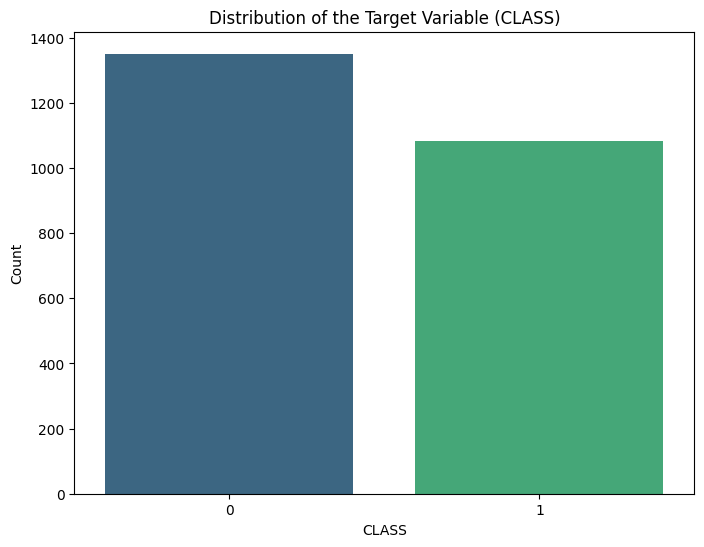

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='CLASS', data=data, palette= 'viridis', hue = 'CLASS', legend = False)
plt.title('Distribution of the Target Variable (CLASS)')
plt.xlabel('CLASS')
plt.ylabel('Count')
plt.show()

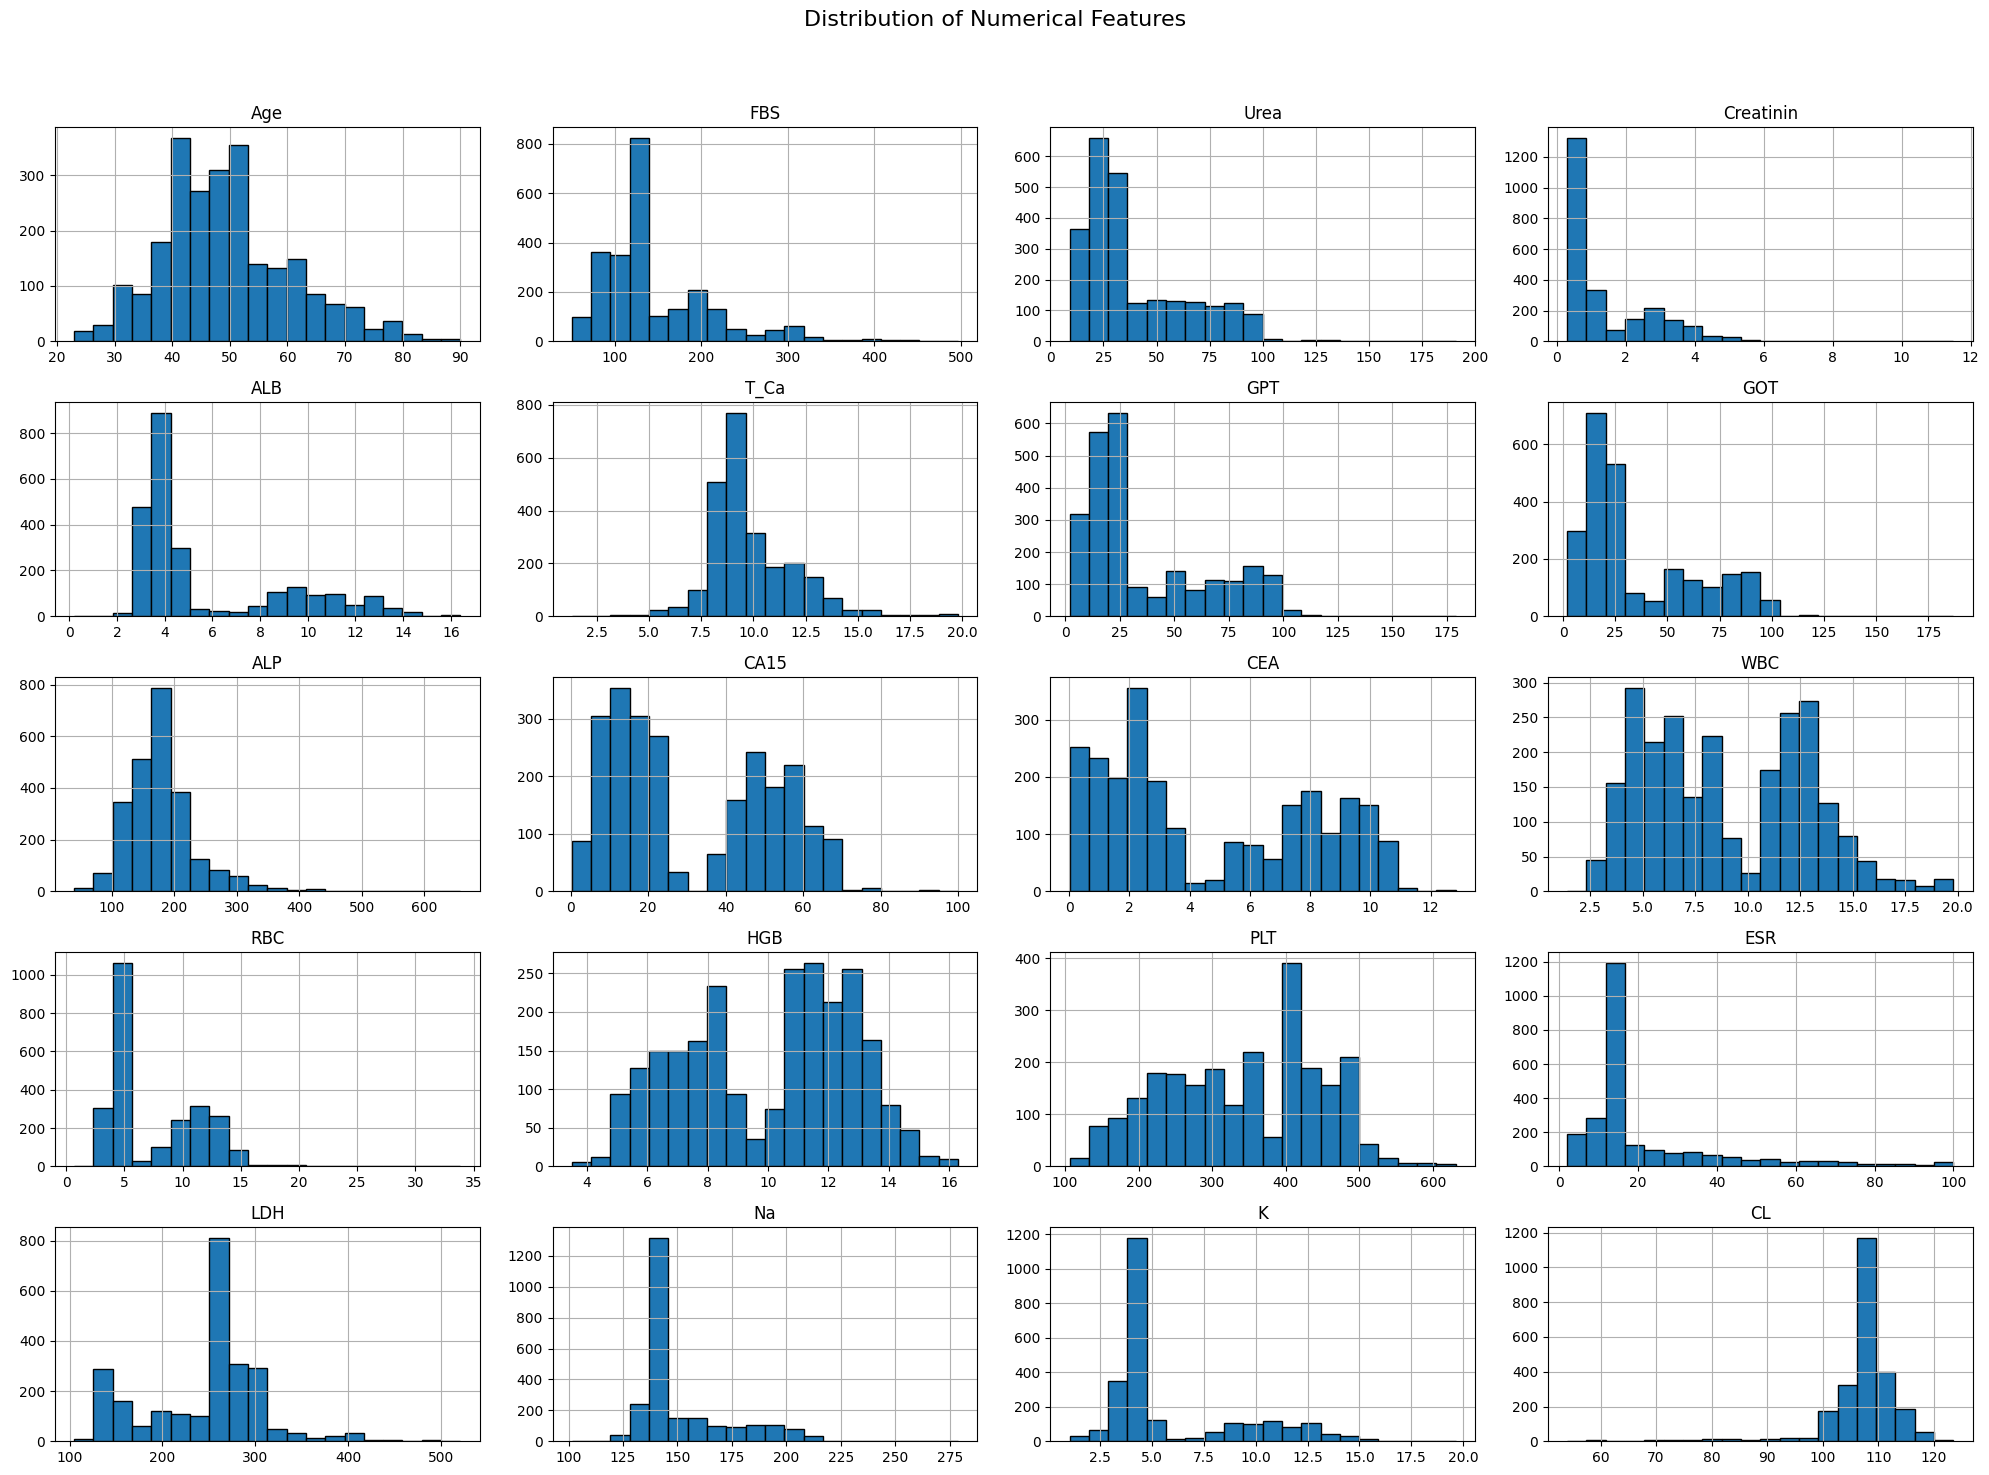

In [8]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop(['CLASS', 'Sex'])
data[numerical_features].hist(figsize=(20, 15), bins=20, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Categorization of Variables by Type and Purpose

Categorizing the variables is essential for effectively organizing and interpreting the dataset. Dividing the variables into distinct groups (demographic, biochemical and clinical, and cancer-specific biomarkers) helps identify relevant patterns, analyze significant correlations, and structure the analysis better for predicting the target variable. This segmentation also aids in understanding the role of each variable in the medical and diagnostic context.


## Demographic and categorial variables
Adress  -  Age  -  Sex

### *Adress* 

Given the high number of sampled cities, we chose to categorize them into the three major Libian regions: Tripolitania, Cirenaica and Fezzan

In [9]:
data['Adress'].unique()

array(['Tragan', 'Sabha', 'Obaree-center', 'Alchate', 'Morzek',
       'Alzeegan', 'Algatroon', 'Godoha', 'Zoiwela', 'OmAlrianb',
       'Tripoli', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath',
       'Benwalid', 'Temcian', 'Alzwia-Algrbia', 'Magdool', 'BenGawoad',
       'Alagialt', 'Agdabia', 'GaberOan', 'Subrath', 'ALzentan',
       'Benghazi', 'Tegee', 'Graian', 'Zwoarha', 'sabha'], dtype=object)

In [10]:
# Definizione delle regioni
Tripolitania = [
    'Tripoli', 'Benwalid', 'Subrath', 'ALzentan', 'Tegee', 'Graian', 
    'Zwoarha', 'Alagialt', 'Zoiwela'
]
Cirenaica = [
    'Benghazi', 'Agdabia', 'GaberOan', 'Alzwia-Algrbia', 'Magdool', 
    'BenGawoad', 'Alzeegan'
]
Fezzan = [
    'Sabha', 'sabha' ,'Tragan', 'Obaree-center', 'Alchate', 'Morzek', 'Algatroon', 
    'Godoha', 'OmAlrianb', 'Wade-atebah', 'Temaciha', 'Algofra', 'Gath', 'Temcian'
]

# Funzione per classificare le regioni
def classify_region_numeric(adress):
    if adress in Tripolitania:
        return 1  # Tripolitania
    elif adress in Cirenaica:
        return 2  # Cirenaica
    elif adress in Fezzan:
        return 3  # Fezzan


# Applica la funzione alla colonna 'Adress' e assicurati che il risultato sia di tipo intero
data['Adress'] = data['Adress'].apply(classify_region_numeric)

# Visualizza i risultati
#print(data['Adress'])

In [11]:
count_Tripolitania = len(data[(data['Adress'] == 1)])
count_Cirenaica = len(data[(data['Adress'] == 2)])
count_Fezzan = len(data[(data['Adress'] == 3)])
print(count_Tripolitania)
print(count_Cirenaica)
print(count_Fezzan)

88
46
2301


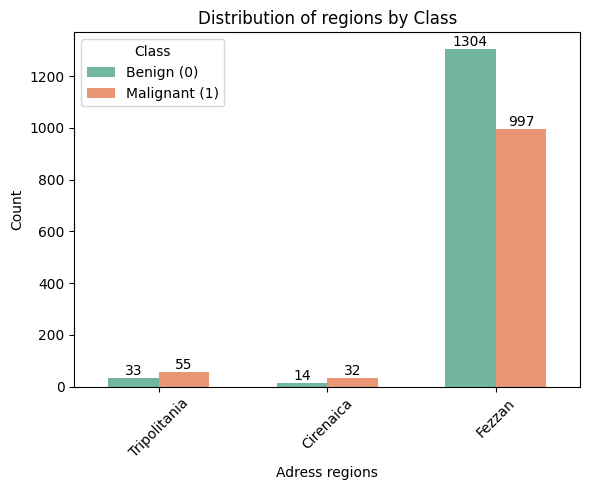

In [12]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=data, x='Adress', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

# Replace x-axis labels with custom names
custom_labels = ['Tripolitania', 'Cirenaica', 'Fezzan']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

plt.title('Distribution of regions by Class')
plt.xlabel('Adress regions')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'], loc="upper left")
plt.tight_layout()

plt.show()

As an initial educated guess, Adress will probably have a small impact on the predictions, since almost all individuals were sampled in the same region (Fezzan)

### *Age*

Following a similar reasoning, we also created three major age groups. The thresholds were chosen to reflect known ages brackets. Usually, the most affected individuals are women of older age.

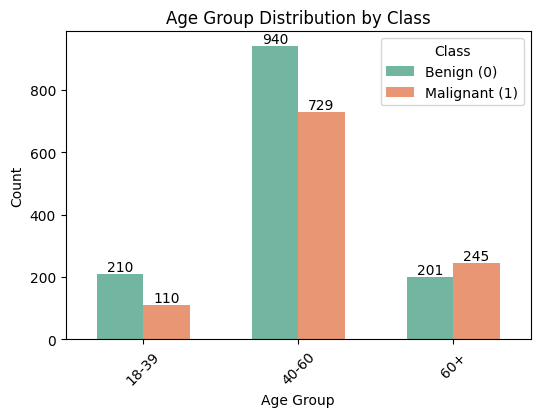

In [13]:
# Define the bins and labels
bins = [18, 39, 60, float('inf')]  # age ranges
labels = [1,2,3]  # 1=18-39, 2=40-60, 3=60+

# Categorize the ages into groups
data['Age'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Create the grouped bar plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=data, x='Age', hue='CLASS', palette='Set2', width=0.6)  # width set to 0.6

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )
# Replace x-axis labels with custom names
custom_labels = ['18-39', '40-60', '60+']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Age Group Distribution by Class')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

The barplots reflect what previously mentioned. Middle-aged people were the most sampled, but breast cancer is more prevalent in individuals aged 60+

### *Sex*

We expect breast cancer to have a much larger impact on female individuals.

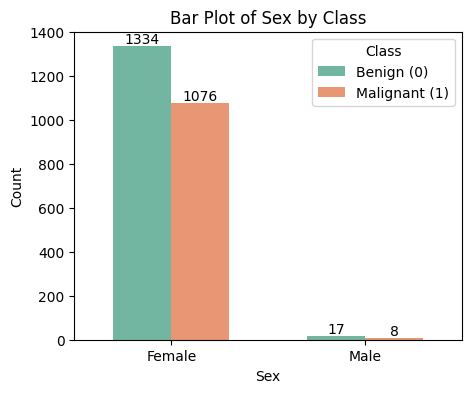

In [14]:
# Create the bar plot
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=data, x='Sex', hue='CLASS', palette='Set2', width=0.6)

# Add numbers on top of each bar
for bar in ax.patches:
    if bar.get_height() > 0:  # Only add text if height > 0
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate (center of the bar)
            bar.get_height(),                  # y-coordinate (height of the bar)
            int(bar.get_height()),             # Text (height value)
            ha='center', va='bottom',          # Alignment
            fontsize=10                        # Font size
        )

custom_labels = ['Female', 'Male']
ax.set_xticks(range(len(custom_labels)))
ax.set_xticklabels(custom_labels)

# Add labels and title
plt.title('Bar Plot of Sex by Class')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Benign (0)', 'Malignant (1)'])
plt.show()

Almost all sampled individuals are females. Again, we can deduce that the Sex variable won't have much impact on the prediction.

In [15]:
count_class_0 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 0)])
count_class_1 = len(data[(data['Sex'] == 1) & (data['CLASS'] == 1)])

print(count_class_0)
print(count_class_1)

print()
count_class_2 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 0)])
count_class_3 = len(data[(data['Sex'] == 2) & (data['CLASS'] == 1)])
print(count_class_2)
print(count_class_3)


1334
1076

17
8


## Biochemical and Clinical Variables
FBS - Urea - Creatinin - ALB - T_Ca - GPT (ALT) - GOT (AST) - ALP - WBC - RBC - HGB - PLT - ESR - LDH - Na - K - CL

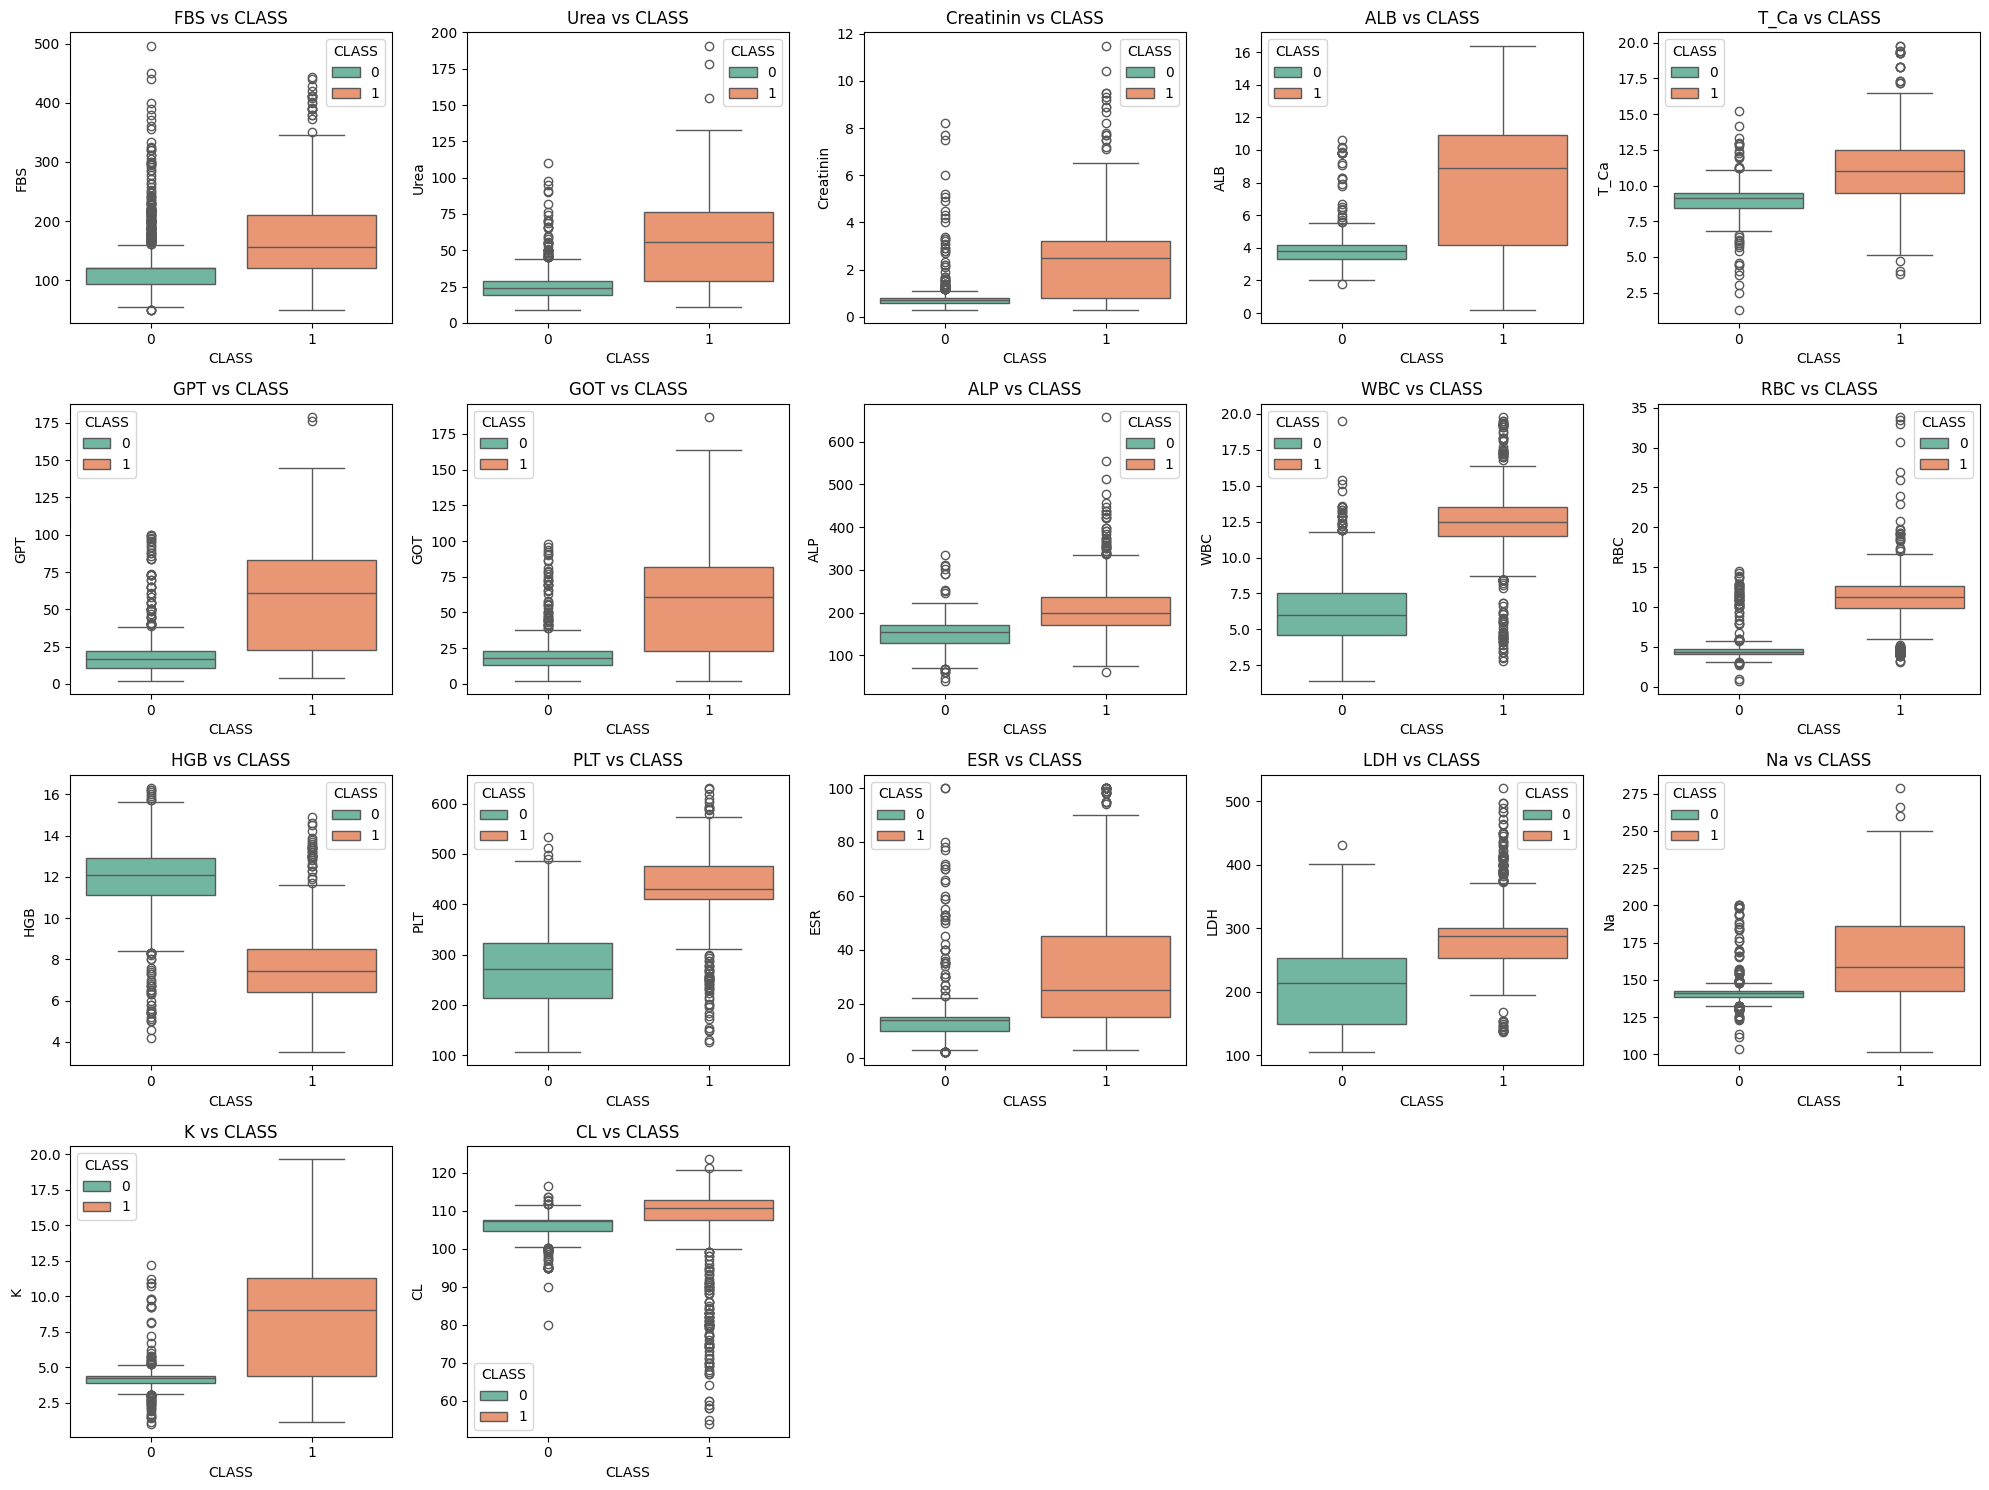

{'Correlations': CLASS        1.000000
 RBC          0.806285
 WBC          0.806098
 PLT          0.757423
 GOT          0.674769
 GPT          0.669495
 ALB          0.661895
 Urea         0.628102
 LDH          0.626307
 K            0.606510
 Creatinin    0.591893
 Na           0.547047
 ALP          0.542504
 ESR          0.519487
 T_Ca         0.499334
 FBS          0.391418
 CL           0.139497
 HGB         -0.789147
 Name: CLASS, dtype: float64}

In [16]:
biochemical_clinical_vars = [
    'FBS', 'Urea', 'Creatinin', 'ALB', 'T_Ca', 'GPT', 'GOT', 'ALP',
    'WBC', 'RBC', 'HGB', 'PLT', 'ESR', 'LDH', 'Na', 'K', 'CL'
]


correlations = data[biochemical_clinical_vars + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)


plt.figure(figsize=(20, 15))
for i, var in enumerate(biochemical_clinical_vars, 1):
    plt.subplot(4, 5, i)
    sns.boxplot(data=data, x='CLASS', y=var, palette="Set2", hue='CLASS')
    plt.title(f'{var} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(var)
plt.tight_layout()
plt.show()


{
    "Correlations": correlations
}


### Results summary:

The correlation analysis reveals key insights into the relationship between biochemical and clinical variables with the target variable `CLASS` (cancer presence). Variables like **RBC**, **WBC**, and **PLT** show strong positive correlations (>0.75), suggesting that higher levels of these markers are strongly associated with cancer. Similarly, liver function enzymes such as **GOT** and **GPT**, as well as markers like **ALB**, **Urea**, and **LDH**, also demonstrate moderate to strong correlations with `CLASS`, indicating their potential relevance in cancer diagnosis.

Interestingly, **HGB** (Hemoglobin) is the only variable showing a strong negative correlation (-0.79), suggesting that lower levels are indicative of cancer presence. Other variables such as **CL** and **T_Ca** show weak correlations, indicating limited significance in differentiating between `CLASS` values.

These findings highlight the importance of blood markers and biochemical parameters in identifying cancer presence, with some variables (e.g., **RBC**, **WBC**, **PLT**) potentially serving as strong predictors for classification models. Further statistical tests and predictive modeling could refine these observations.

## Cancer Specific Biomarkers
CA15 -  CEA

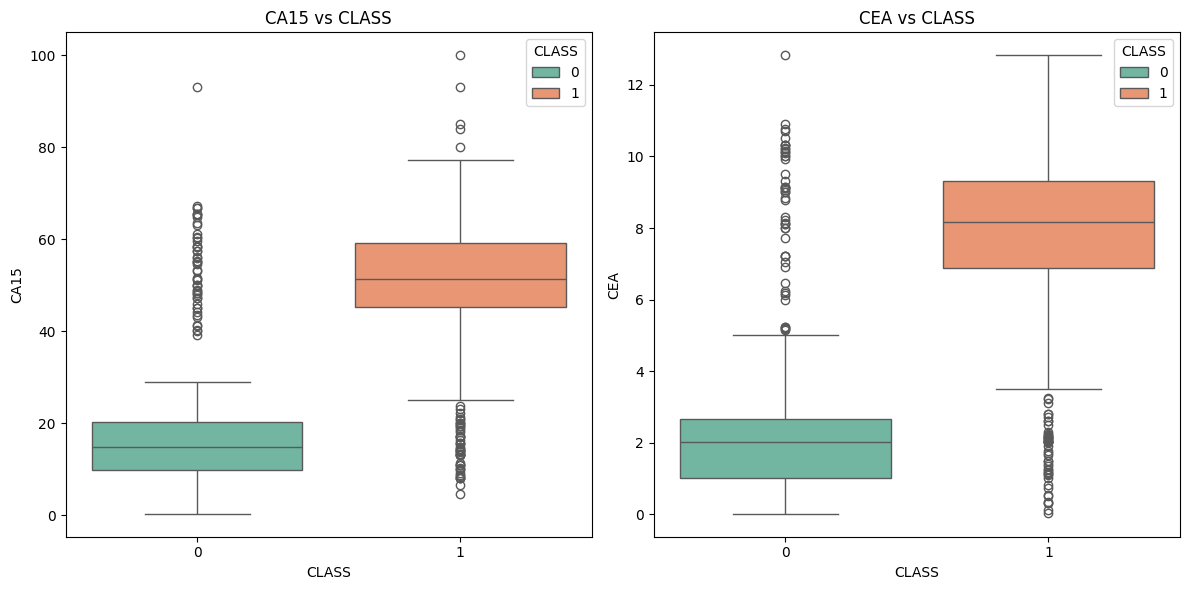

{'Correlations': CLASS    1.000000
 CA15     0.852288
 CEA      0.843010
 Name: CLASS, dtype: float64}

In [17]:
cancer_biomarkers = ['CA15', 'CEA']

# 1. Correlation with CLASS
biomarker_correlations = data[cancer_biomarkers + ['CLASS']].corr()['CLASS'].sort_values(ascending=False)

# 2. Boxplot visualization for each biomarker
plt.figure(figsize=(12, 6))
for i, biomarker in enumerate(cancer_biomarkers, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data, x='CLASS', y=biomarker, palette="Set2", hue = "CLASS")
    plt.title(f'{biomarker} vs CLASS')
    plt.xlabel('CLASS')
    plt.ylabel(biomarker)
plt.tight_layout()
plt.show()


# Results
{
    "Correlations": biomarker_correlations,
}


### Results Summary:

The correlation analysis highlights the strong relationship between cancer-specific biomarkers (**CA15** and **CEA**) and the target variable `CLASS` (cancer presence). **CA15** shows a very high positive correlation (**0.85**), indicating its effectiveness as a diagnostic marker, particularly for breast cancer. Similarly, **CEA** demonstrates a strong positive correlation (**0.84**), reinforcing its role as a versatile biomarker for various types of cancer.

These findings emphasize the critical importance of **CA15** and **CEA** in identifying cancer presence and their potential as primary predictors in diagnostic models. Further analysis and validation could enhance their utility in clinical applications.

## Correlation Matrix

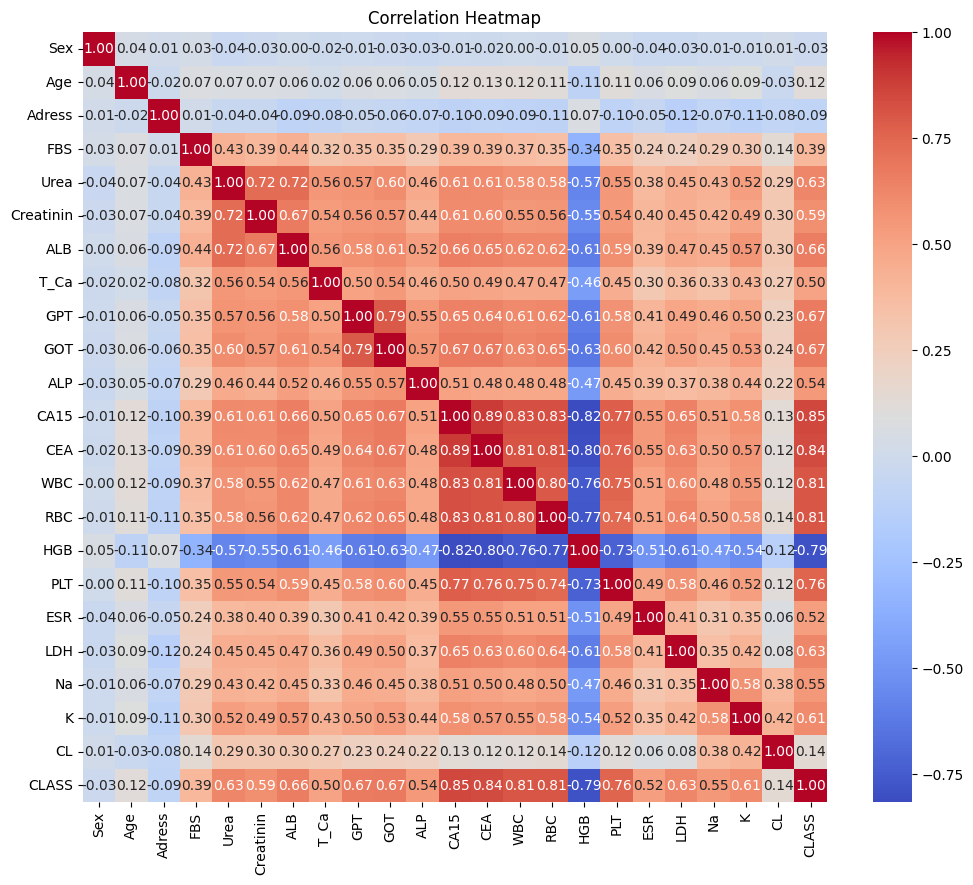

In [18]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

### bisogna dire tipo come nelle analisi precendi eccc



The correlation heatmap reveals various relationships between variables. Strong correlations exist between biomarkers like **CA15**, **CEA**, **RBC**, and **WBC**, suggesting they are related and may reflect similar physiological processes. Conversely, **CL** and **Na** show weak correlations with most other variables, indicating limited relevance. **HGB** displays a strong negative correlation with others, highlighting distinct relationships. Additionally, **Age**, **Sex**, and **Adress** show weak or no significant correlations with most features, suggesting they might not contribute strongly to the variability in the dataset or the target variable, **CLASS**. These findings highlight the importance of focusing on key biomarkers for further analysis.

## Variance Inflation Factor

In [19]:
# Add a constant (intercept) column to the dataset for calculating VIF
features_const = sm.add_constant(data.drop(columns=['CLASS']))

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = features_const.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features_const.values, i) for i in range(features_const.shape[1])]

# Display the results
print(vif_data)


      Feature         VIF
0       const  663.048743
1         Sex    1.020131
2         Age    1.028438
3      Adress    1.037707
4         FBS    1.324068
5        Urea    2.923543
6   Creatinin    2.550706
7         ALB    2.924009
8        T_Ca    1.761598
9         GPT    3.022997
10        GOT    3.345852
11        ALP    1.719317
12       CA15    6.996620
13        CEA    6.130112
14        WBC    4.068009
15        RBC    4.227141
16        HGB    3.680568
17        PLT    3.052135
18        ESR    1.532144
19        LDH    1.897387
20         Na    1.767227
21          K    2.194868
22         CL    1.459996


# Selection, Description and possibly comparison of the most suitable statistical models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Feature selection (forward selection)

In [32]:
X_f = data.drop(columns=['CLASS'])
y_f = data['CLASS']

# Forward Selection Function
def forward_selection(X, y):
    initial_features = X.columns.tolist()
    selected_features = []
    while initial_features:
        remaining_features = list(set(initial_features) - set(selected_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)

        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            new_pval[feature] = model.pvalues[feature]
        
        min_pval = new_pval.min()
        if min_pval < 0.05:  # Set significance level
            selected_features.append(new_pval.idxmin())
        else:
            break

    return selected_features

selected_features = forward_selection(X_f, y_f)
print("Selected features:", selected_features)


Selected features: ['WBC', 'CA15', 'CEA', 'GPT', 'RBC', 'Na', 'HGB', 'ALP', 'PLT', 'Urea', 'CL', 'K', 'LDH']


In [21]:
# Split the dataset into features and target
X = data.drop(columns=['CLASS'])
y = data['CLASS']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform the data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler (to avoid data leakage)
X_test_scaled = scaler.transform(X_test)


## Logistic Regression

In [22]:

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)

print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.9548254620123203

Confusion Matrix:
 [[257  15]
 [  7 208]]


## Decision Tree

In [23]:
# Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=61)
dt_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test_scaled)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

print("Accuracy:", accuracy_dt)

print("\nConfusion Matrix:\n", conf_matrix_dt)


Accuracy: 0.9609856262833676

Confusion Matrix:
 [[262  10]
 [  9 206]]


## Random Forest

In [24]:
# Initialize and train the model
rf_model = RandomForestClassifier(random_state=61)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Accuracy:", accuracy_rf)

print("\nConfusion Matrix:\n", conf_matrix_rf)


Accuracy: 0.9650924024640657

Confusion Matrix:
 [[256  16]
 [  1 214]]


## Ridge Classifier

In [25]:
from sklearn.linear_model import RidgeClassifier

# Initialize and train the model
ridge_model = RidgeClassifier()
ridge_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate the model
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
conf_matrix_ridge = confusion_matrix(y_test, y_pred_ridge)

print("Accuracy:", accuracy_ridge)

print("\nConfusion Matrix:\n", conf_matrix_ridge)


Accuracy: 0.9568788501026694

Confusion Matrix:
 [[257  15]
 [  6 209]]


## Results

In [26]:
# Results summary for comparison
results = {
    'Logistic Regression': {'Accuracy': accuracy, 'Confusion Matrix': conf_matrix},
    'Decision Tree': {'Accuracy': accuracy_dt, 'Confusion Matrix': conf_matrix_dt},
    'Random Forest': {'Accuracy': accuracy_rf, 'Confusion Matrix': conf_matrix_rf},
    'Ridge Classifier': {'Accuracy': accuracy_ridge, 'Confusion Matrix': conf_matrix_ridge}
}

results


{'Logistic Regression': {'Accuracy': 0.9548254620123203,
  'Confusion Matrix': array([[257,  15],
         [  7, 208]])},
 'Decision Tree': {'Accuracy': 0.9609856262833676,
  'Confusion Matrix': array([[262,  10],
         [  9, 206]])},
 'Random Forest': {'Accuracy': 0.9650924024640657,
  'Confusion Matrix': array([[256,  16],
         [  1, 214]])},
 'Ridge Classifier': {'Accuracy': 0.9568788501026694,
  'Confusion Matrix': array([[257,  15],
         [  6, 209]])}}

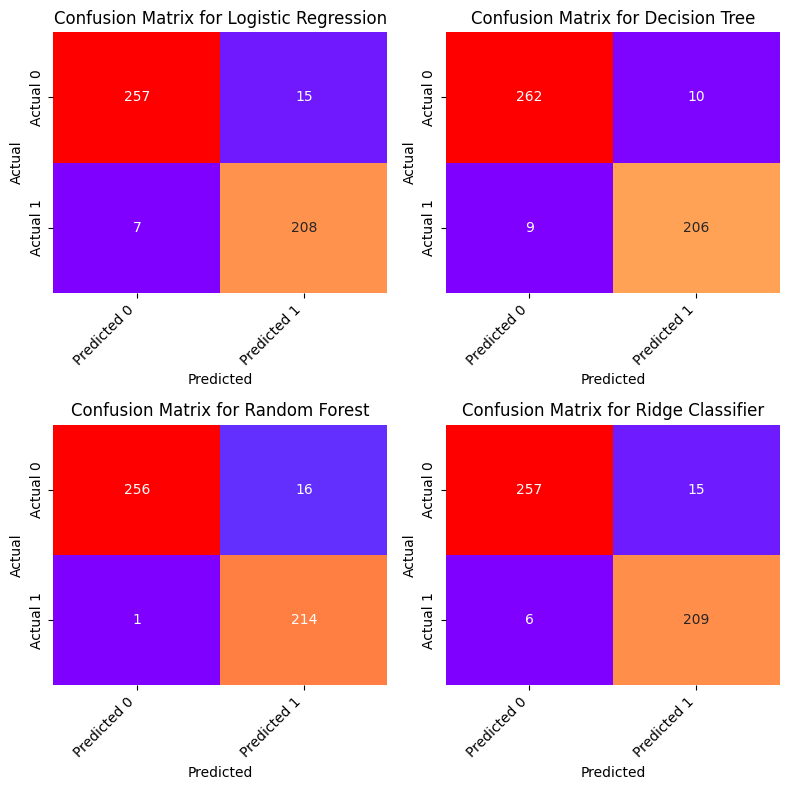

In [27]:
model_names = list(results.keys())

# Visualizing confusion matrices as heatmaps in a 2x2 matrix layout for all models
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Iterate through the models and plot the confusion matrix for each
for i, model in enumerate(model_names):
    conf_matrix = results[model]['Confusion Matrix']
    ax = axes[i//2, i%2]  # Get the appropriate axis
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rainbow', cbar=False, 
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f'Confusion Matrix for {model}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()



# Grafici e alberi se si vuole far vedere se no si toglie

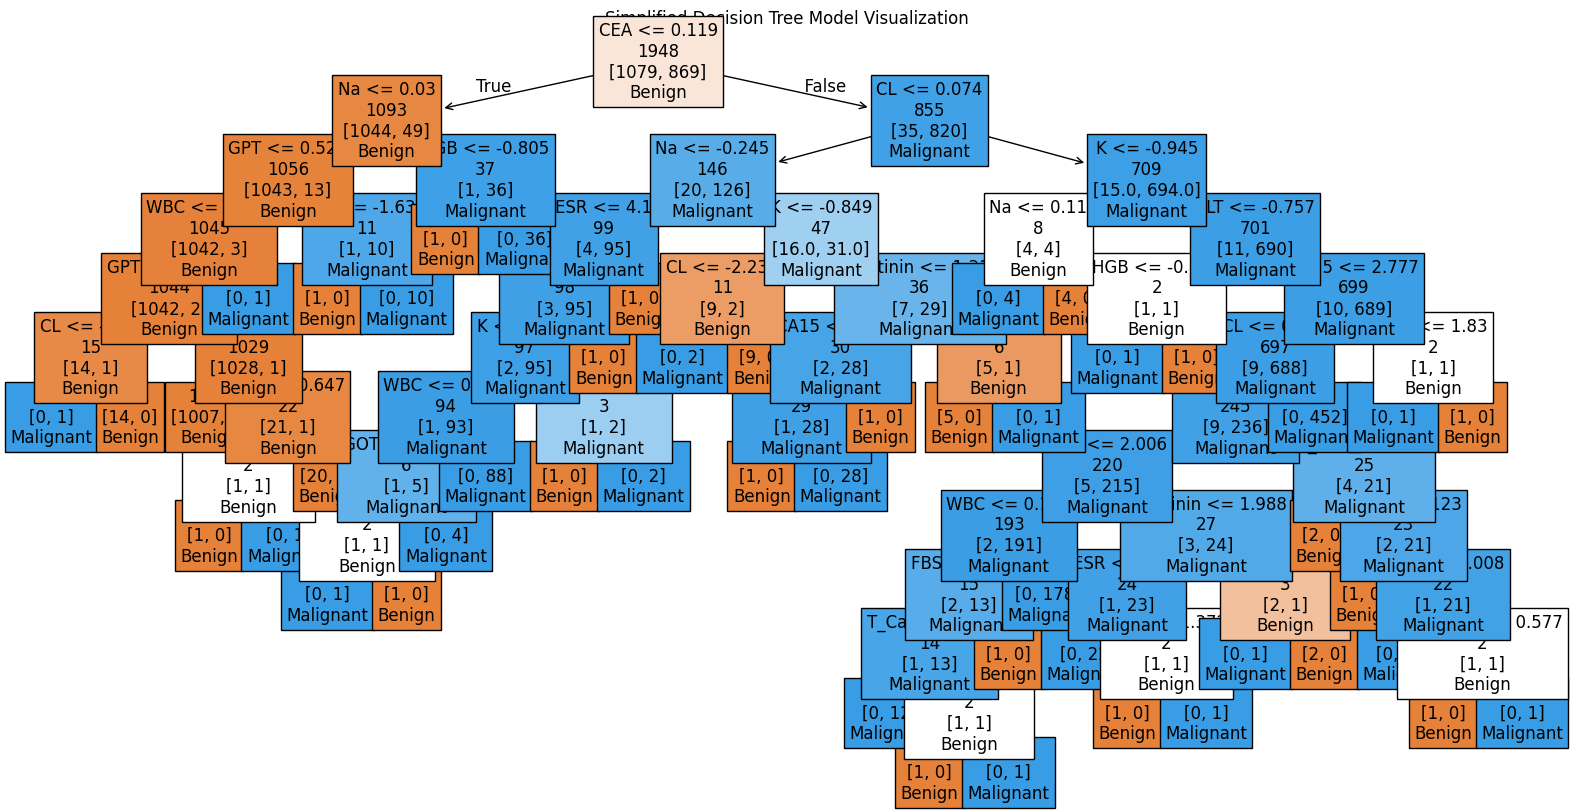

In [28]:


# Visualizing the Decision Tree with only feature names and class labels, excluding other details
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Benign', 'Malignant'],  
          label='none',  
          impurity=False,  
          proportion=False,  
          node_ids=False, 
          fontsize=12)
plt.title("Simplified Decision Tree Model Visualization")
plt.show()


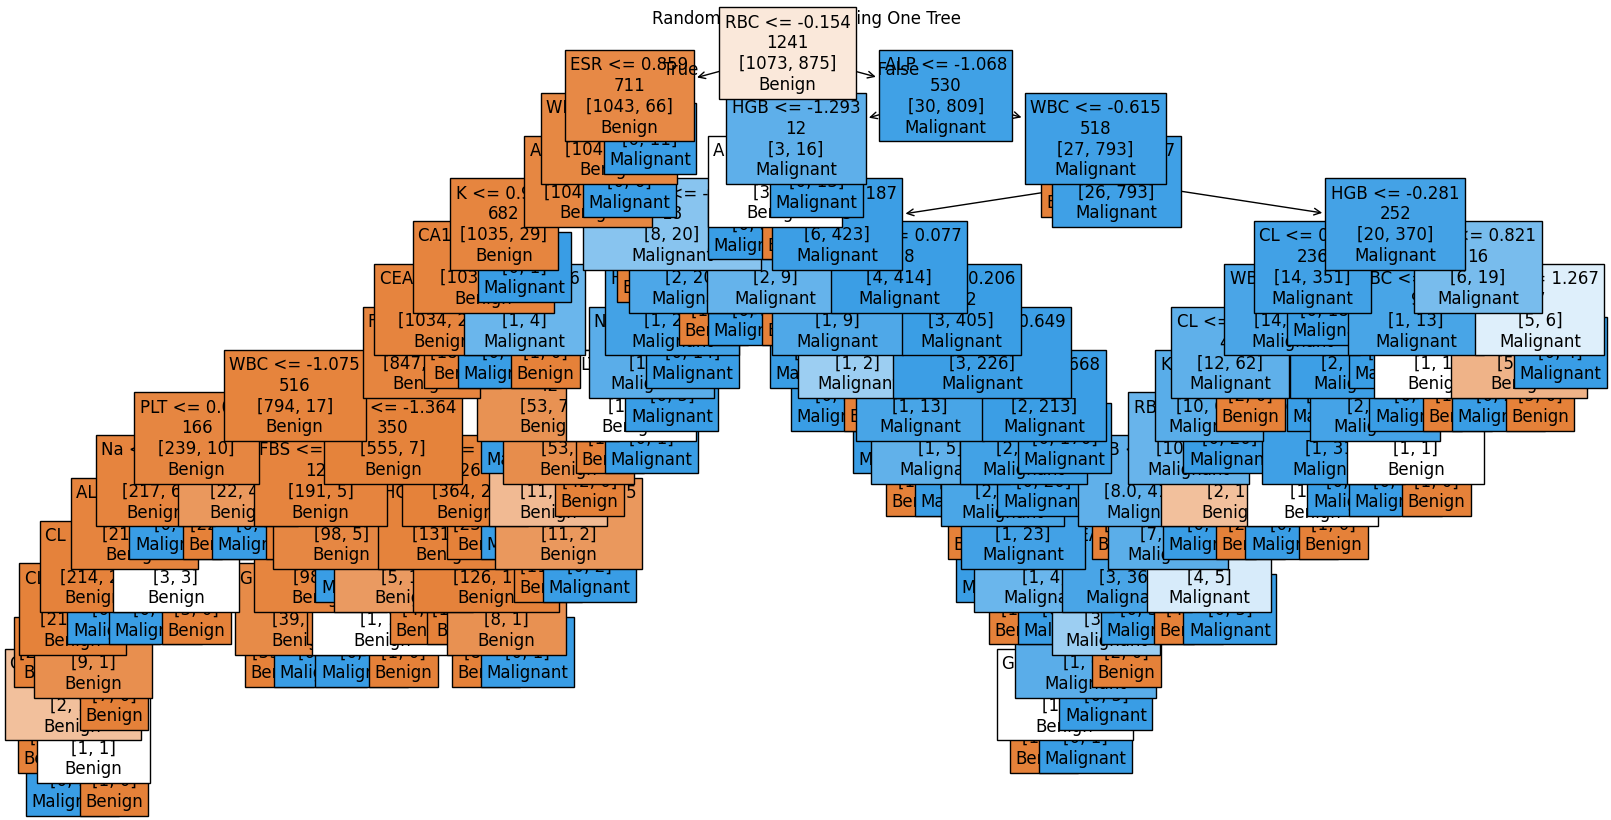

In [29]:
tree_rf = rf_model.estimators_[61]


# Visualizing the Decision Tree with only feature names and class labels, excluding other details
plt.figure(figsize=(20, 10))
plot_tree(tree_rf, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Benign', 'Malignant'],  
          label='none',  
          impurity=False,  
          proportion=False,  
          node_ids=False, 
          fontsize=12)
plt.title("Random Forest - Visualizing One Tree")
plt.show()

# GAM   Grandi smeni, smeni duri cazzi amari cazzi in golas

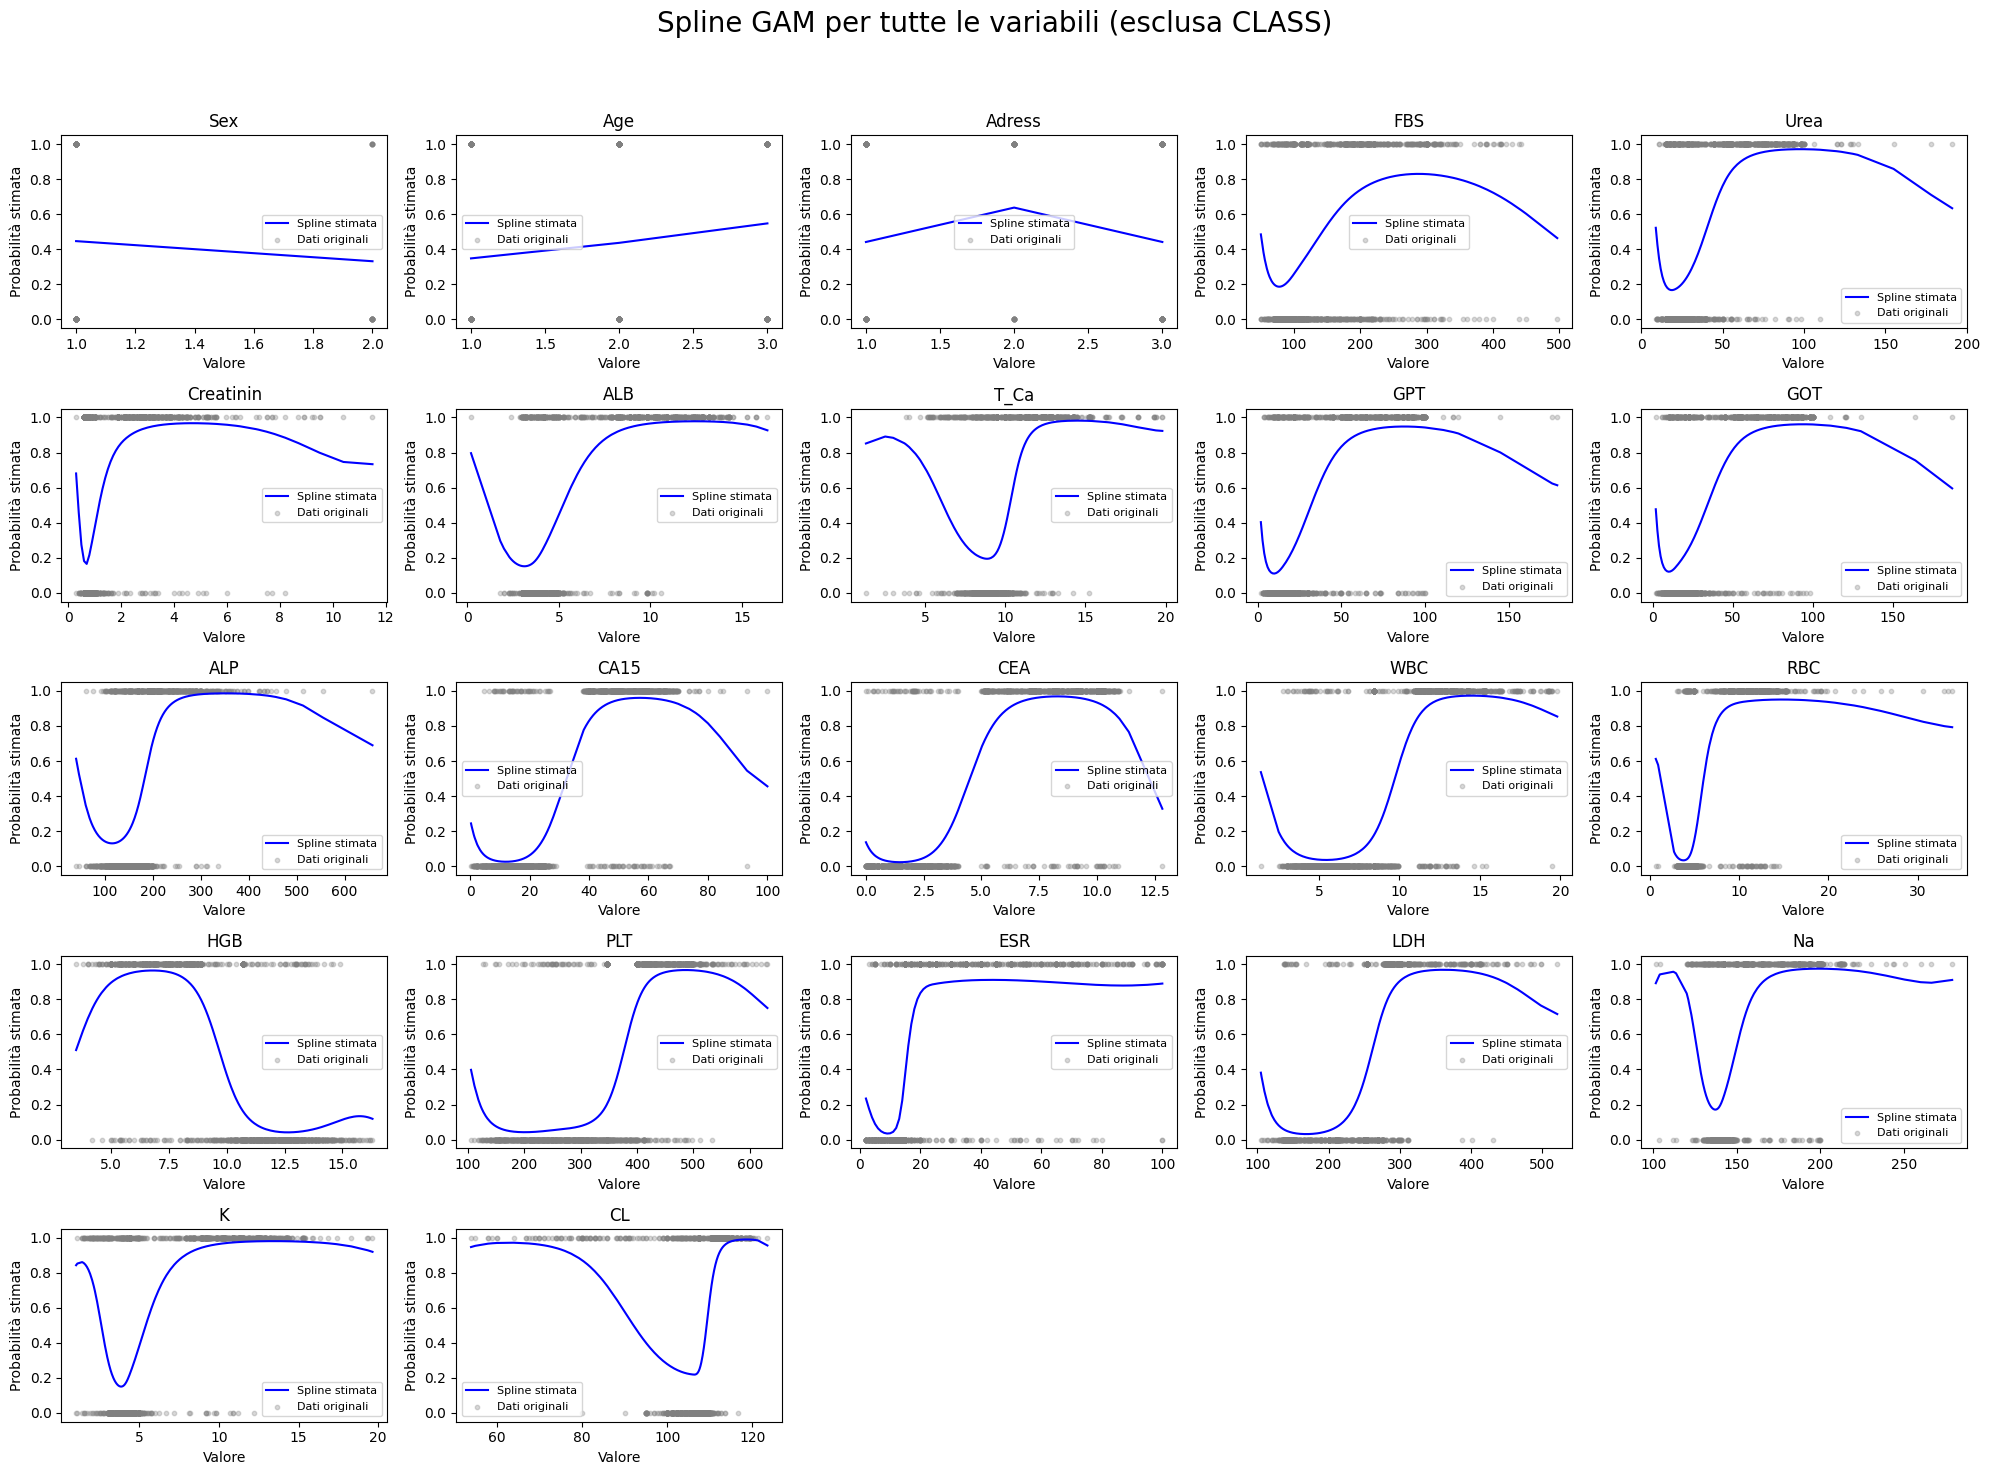

In [30]:
from patsy import dmatrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Creazione di una griglia di grafici compatti 5x5
plt.figure(figsize=(20, 15))
num_cols = 5
num_rows = (len(data.columns) - 1) // num_cols + 1  # Escludendo CLASS

subplot_idx = 1  # Contatore per le sottotrame

for col in data.columns:
    if col == 'CLASS':  # Salta la colonna target
        continue

    # Generazione delle spline
    X_spline = dmatrix(f"bs(train, df=6, degree=3, include_intercept=False)", 
                       {"train": data[col]}, return_type='dataframe')

    # Adattamento di un modello GAM semplice
    model = LogisticRegression(max_iter=1000).fit(X_spline, y)

    # Predizione delle probabilità
    y_pred_prob = model.predict_proba(X_spline)[:, 1]

    # Ordinare i dati per una migliore visualizzazione
    sorted_indices = data[col].argsort()
    col_sorted = data[col].iloc[sorted_indices]
    y_pred_sorted = y_pred_prob[sorted_indices]

    # Sottotrama per la variabile
    plt.subplot(num_rows, num_cols, subplot_idx)
    plt.plot(col_sorted, y_pred_sorted, label='Spline stimata', color='blue')
    plt.scatter(data[col], y, alpha=0.3, color='gray', label='Dati originali', s=10)
    plt.title(col)
    plt.xlabel("Valore")
    plt.ylabel("Probabilità stimata")
    plt.legend(fontsize=8)
    
    subplot_idx += 1  # Incrementa l'indice della sottotrama

plt.suptitle("Spline GAM per tutte le variabili (esclusa CLASS)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Aggiustare lo spazio per il titolo
plt.show()


da capire le librerie gam su python


In [31]:
from pygam import LogisticGAM, s

# Fit GAM
gam = LogisticGAM(s(0) + s(1) + s(2)).fit(X_train.values, y_train)
print(gam.summary())

# Plot GAM terms
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.set_title(f'Term {i}')
plt.show()



ModuleNotFoundError: No module named 'pygam'

# Comments on results

In [1]:
print()